# Importing Libraries

In [ ]:
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Connection to drive

In [ ]:
try:
    from google.colab import drive
    IN_COLAB = True
    print("Running on Google Colab. ")
except:
    IN_COLAB = False
    print("Not running on Google Colab. ")

Running on Google Colab. 


In [ ]:
if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
if IN_COLAB:
    os.chdir('/content/gdrive/MyDrive/Tesi/dataset')

# Reading and Merging Data

In [ ]:
import zipfile

extract_dir = "./LUFlow"

if not os.path.exists("./LUFlow"):

    zip_file_path = "./LUFlow.zip"

    # Open the zip file and extract all the files
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(extract_dir)

    print("Files extracted successfully.")
else:
    print('Already extracted')

Already extracted


In [ ]:
df_list = []
i = 0

for root, dirs, files in os.walk(extract_dir):
    for file in files:
        # checks if 'file' does not exist in the directory
        # checks if 'csv' is in the file name
        # checks if a particular string is in the file name
        # insert in the list only a subset of the existing files
        if not os.path.isfile(file) and 'csv' in file and '2020.08' in file and i < 6:
            df_list.append(pd.read_csv(os.path.join(root, file)))
            i+=1

perc = 0.8

files_perc = int(len(df_list) * perc)
print(f'Num files: {files_perc}')

df = pd.concat(df_list[:files_perc])
df_test = pd.concat(df_list[files_perc:])

df = pd.concat(df_list, ignore_index=True)
len(df.columns)

Num files: 4


16

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4516035 entries, 0 to 4516034
Data columns (total 16 columns):
 #   Column         Dtype  
---  ------         -----  
 0   avg_ipt        float64
 1   bytes_in       int64  
 2   bytes_out      int64  
 3   dest_ip        int64  
 4   dest_port      float64
 5   entropy        float64
 6   num_pkts_out   int64  
 7   num_pkts_in    int64  
 8   proto          int64  
 9   src_ip         int64  
 10  src_port       float64
 11  time_end       int64  
 12  time_start     int64  
 13  total_entropy  float64
 14  label          object 
 15  duration       float64
dtypes: float64(6), int64(9), object(1)
memory usage: 551.3+ MB


# Exploratory Data Analysis

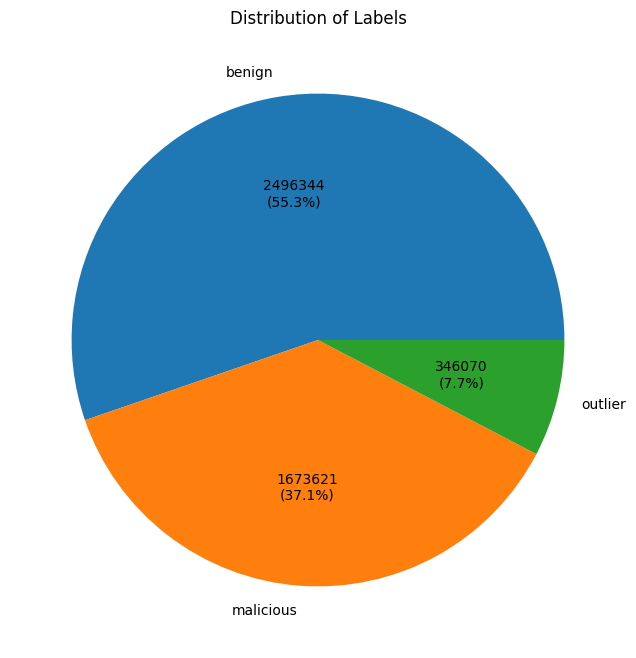

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Count the occurrences of each label
label_counts = df['label'].value_counts()

# Plot using Matplotlib
plt.figure(figsize=(8, 8))
plt.pie(label_counts, labels=label_counts.index, autopct=lambda p: '{:.0f}\n({:.1f}%)'.format(p * sum(label_counts) / 100, p))

# Show the plot
plt.title('Distribution of Labels')
plt.show()

# Data Preprocessing

In [ ]:
outliers = df['label'] == 'outlier'
df = df[~outliers]

df = df.reset_index(drop=True)

In [ ]:
outliers = df_test['label'] == 'outlier'
df_test = df_test[~outliers]

df_test = df_test.reset_index(drop=True)

In [ ]:
columns_to_drop = ['avg_ipt', 'dest_ip', 'dest_port', 'entropy', 'src_ip', 'src_port', 'time_end', 'total_entropy', 'duration']

# Drop specified columns
df = df.drop(columns=columns_to_drop)

df_test = df_test.drop(columns=columns_to_drop)

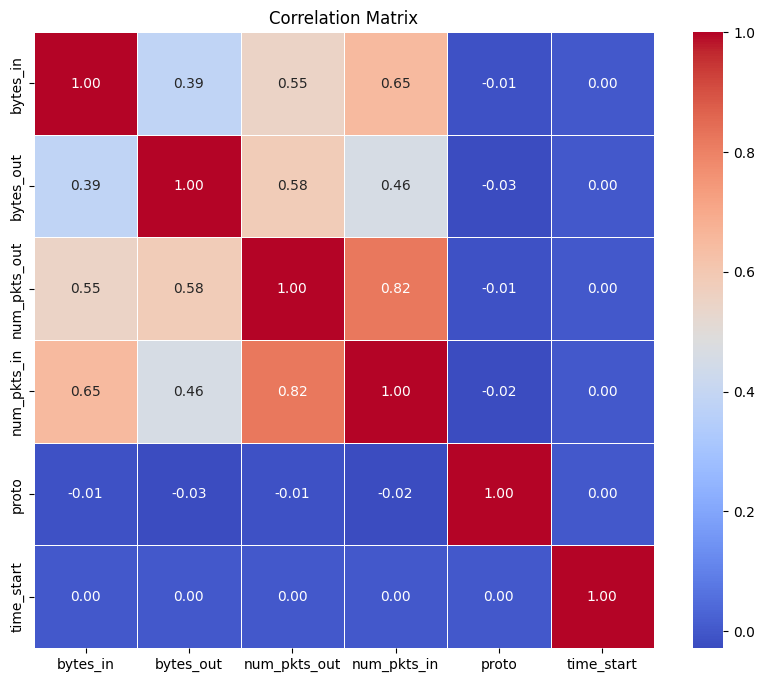

In [ ]:
# Calculate correlation matrix
correlation_matrix = df.drop('label', axis=1).corr()

# Create a heatmap using Seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

In [ ]:
df.dropna(axis=1, inplace = True)
df_test.dropna(axis=1, inplace = True)

missing_values = df.isnull().sum()

print(missing_values)

bytes_in        0
bytes_out       0
num_pkts_out    0
num_pkts_in     0
proto           0
time_start      0
label           0
dtype: int64


In [ ]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

# Fit and transform the label column
df['label'] = label_encoder.fit_transform(df['label'])
df_test['label'] = label_encoder.fit_transform(df_test['label'])

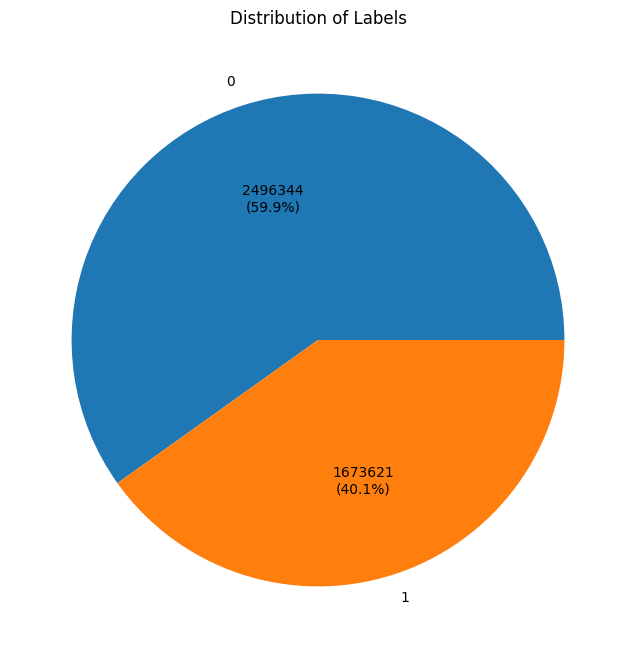

In [ ]:
# Count the occurrences of each label
label_counts = df['label'].value_counts()

plt.figure(figsize=(8, 8))
plt.pie(label_counts, labels=label_counts.index, autopct=lambda p: '{:.0f}\n({:.1f}%)'.format(p * sum(label_counts) / 100, p))
# Show the plot
plt.title('Distribution of Labels')
plt.show()

In [ ]:
df.columns

Index(['bytes_in', 'bytes_out', 'num_pkts_out', 'num_pkts_in', 'proto',
       'time_start', 'label'],
      dtype='object')

### Preparation of index for the granules varying time window dimensions

In [ ]:
time_slices = [16, 128, 256, 1024, 2048, 3016]

matching_indices_slices = {}

for ts in time_slices:
  # maximum time limit of the granule
  limit = df.iloc[0]['time_start'] + ts
  # number of granules
  num_gran = 0
  matching_indices_slices[ts] = {num_gran:[0]}

  for i, row in df.iterrows():
      # if the value of time_start is greater than limit then limit is updated and
      # it is initilized a new granule
      # otherwise the index of the row is added to matching_indeces_slices
      if row['time_start'] >= limit:
        limit = row['time_start'] + ts
        num_gran += 1

        matching_indices_slices[ts][num_gran] = [i]
      else:
        if i != 0:
          matching_indices_slices[ts][num_gran].append(i)


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Separate features (X) and target variable (y)
X_train = df.drop('label', axis=1)
y_train = df['label']

X_test = df_test.drop('label', axis=1)
y_test = df_test['label']

In [ ]:
X_train

,bytes_in,bytes_out,num_pkts_out,num_pkts_in,proto,time_start
0,0,190,1,0,6,1596249973518344
1,0,8688,6,0,6,1596249973518885
2,0,190,1,0,6,1596249973523429
3,0,13222,10,0,6,1596249973527246
4,0,0,1,0,6,1596249973527975
...,...,...,...,...,...,...
4169960,0,300,1,0,17,1596758375653629
4169961,0,0,1,0,6,1596758376242287
4169962,56,56,1,1,1,1596758364381853
4169963,112,112,2,2,1,1596758360604994


In [ ]:
y_train

,label
0,0
1,0
2,0
3,0
4,0
...,...
4169960,0
4169961,1
4169962,1
4169963,1


# Model Training and Performance

In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from tqdm import tqdm

In [ ]:
X_train_granule = {}
y_train_granule = {}


for time_slice in tqdm(time_slices):
  X_train_granule[time_slice] = {}
  y_train_granule[time_slice] = {}

  for granule in matching_indices_slices[time_slice]:
    # takes indeces for the specific granule
    granule_indeces = matching_indices_slices[time_slice][granule]

    # does the sum
    X_train_granule[time_slice][granule] = X_train.iloc[granule_indeces][['bytes_in', 'bytes_out', 'num_pkts_out', 'num_pkts_in', 'proto']].sum(axis=0)
    X_train_granule[time_slice][granule]['time_start'] = X_train.iloc[granule_indeces]['time_start'].head(1)

    y_train_granule[time_slice][granule] = y_train.iloc[granule_indeces].mode().iloc[0]



100%|██████████| 6/6 [04:38<00:00, 46.40s/it]


In [ ]:
from tqdm import tqdm
from sklearn.model_selection import KFold

list_reports = {}
best_models = {}

# Random Forest with GridSearchCV
rf_params = {'n_estimators': [50, 100, 200], 'max_depth': [None, 10, 20]}
rf_model = RandomForestClassifier()
rf_grid = GridSearchCV(rf_model, rf_params, cv=10, scoring='accuracy')


for time_slice in tqdm(time_slices):
  y_train_list = list(y_train_granule[time_slice].values())
  X_train_granule_df = pd.DataFrame.from_dict(X_train_granule[time_slice], orient='index')

  list_reports[time_slice] = {}
  best_models[time_slice] = {}

  rf_grid.fit(X_train_granule_df, y_train_list)
  rf_best_model = rf_grid.best_estimator_

  rf_pred = rf_best_model.predict(X_test)
  report = classification_report(y_test, rf_pred, output_dict=True)

  list_reports[time_slice] = pd.DataFrame(report).transpose()
  best_models[time_slice] = rf_best_model


  0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/sklearn/utils/_array_api.py:380: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  array = numpy.asarray(array, order=order, dtype=dtype)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_array_api.py:380: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  array = numpy.asarray(array, order=order, dtype=dtype)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_array_api.py:380: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  array = numpy.asarray(array, order=order, dtype=dtype)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_array_api.py:380: FutureWarning: Calling float on a single element Series is deprecated a

# Model Performance

In [ ]:
import time
import joblib

timestr = time.strftime("%Y%m%d-%H%M%S")

os.mkdir(f'./reports/{timestr}')
os.mkdir(f'./best_models/{timestr}')

os.chdir(f'./reports/{timestr}')

for report in list_reports:
  list_reports[report].to_csv(f'report_{report}.csv')


os.chdir(f'../../best_models/{timestr}')

for model in best_models:
  joblib.dump(best_models[model], f'model_{model}_{timestr}.joblib')

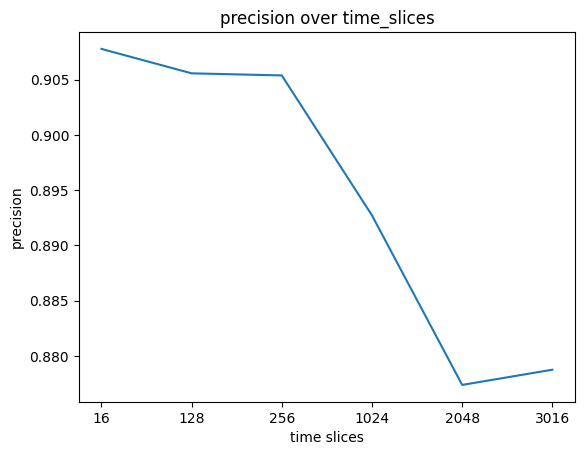

In [ ]:
equidistant_x = np.arange(len(time_slices))
feature_to_print = 'precision'

plt.plot(equidistant_x, [list_reports[i].loc['accuracy'][feature_to_print] for i in time_slices])

plt.title(f'{feature_to_print} over time_slices')
plt.xticks(equidistant_x, time_slices)
plt.xlabel('time slices')
plt.ylabel(f'{feature_to_print}')
# plt.legend()
plt.show()

In [ ]:
for time_slice in time_slices:
  print(f'Report {time_slice}: \n{list_reports[time_slice]}')
  print('\n')

Report 16: 
              precision    recall  f1-score       support
0              0.917027  0.904046  0.910490  6.613240e+05
1              0.898119  0.911825  0.904920  6.134940e+05
accuracy       0.907789  0.907789  0.907789  9.077892e-01
macro avg      0.907573  0.907935  0.907705  1.274818e+06
weighted avg   0.907928  0.907789  0.907810  1.274818e+06


Report 128: 
              precision    recall  f1-score       support
0              0.914591  0.902242  0.908375  6.613240e+05
1              0.896132  0.909176  0.902607  6.134940e+05
accuracy       0.905579  0.905579  0.905579  9.055787e-01
macro avg      0.905362  0.905709  0.905491  1.274818e+06
weighted avg   0.905708  0.905579  0.905599  1.274818e+06


Report 256: 
              precision    recall  f1-score       support
0              0.915087  0.901248  0.908115  6.613240e+05
1              0.895257  0.909851  0.902495  6.134940e+05
accuracy       0.905388  0.905388  0.905388  9.053881e-01
macro avg      0.905172  0.905